<a href="https://colab.research.google.com/github/smallrus-web/AZSII_prz5/blob/main/%D0%90%D1%80%D1%85%D0%B8%D0%BF%D0%BE%D0%B2_%D0%94%D0%BC%D0%B8%D1%82%D1%80%D0%B8%D0%B9_prz5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Группа: ББМО-01-23

Студент: Архипов Дмитрий Евгеньевич



**1.  Загрузка обученной модели и данных MNIST**




In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9733 - loss: 0.0970
Test accuracy on clean images: 0.9768000245094299



**2. Установка Foolbox:**

In [ ]:
pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.6 MB/s eta 0:00:00


**3.  Реализация атаки DeepFool**


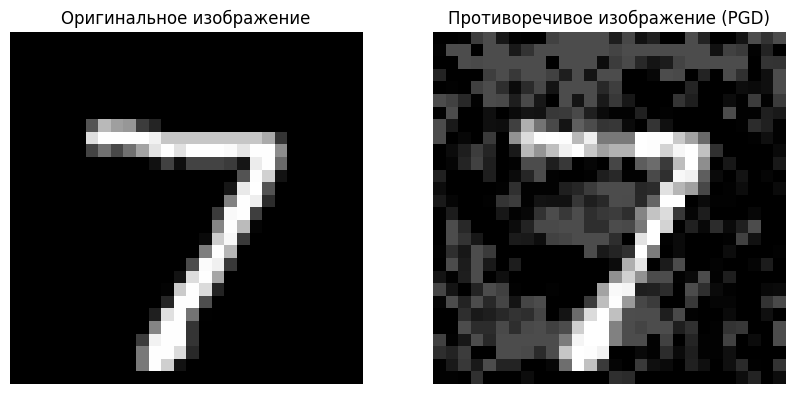

In [ ]:
import foolbox as fb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Предполагается, что model — обученная модель TensorFlow
# Обёртка модели для Foolbox
fmodel = fb.models.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки PGD
attack = fb.attacks.LinfPGD()

# Выбор изображения для атаки
image = test_images[0]
label = test_labels[0]

# Преобразование метки из one-hot в индекс класса
label = np.argmax(label)  # Индекс класса вместо one-hot вектора
label_tensor = tf.convert_to_tensor([label], dtype=tf.int64)

# Преобразование изображения в tf.Tensor
image_tensor = tf.convert_to_tensor(image.reshape(1, 28, 28, 1), dtype=tf.float32)

# Выполнение атаки с заданным epsilon
epsilon = 0.3  # Максимальное изменение пикселей
adversarial_image = attack(fmodel, image_tensor, label_tensor, epsilons=epsilon)

# Если результат атаки возвращает не массив, преобразуйте его
if isinstance(adversarial_image, tuple):
    adversarial_image = adversarial_image[0]

# Преобразование противоречивого изображения обратно в numpy
adversarial_image = adversarial_image.numpy()

# Вывод оригинального и противоречивого изображения
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(adversarial_image[0].reshape(28, 28), cmap="gray")
plt.axis("off")

plt.show()

**4.  Оценка модели на противоречивых примерах**






In [ ]:

adversarial_images = []
# Обработка изображений
for i in range(len(test_images) // 10): # ограничил выборку для ускорения выполнения
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    # Атака на изображение
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)
# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)
# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:1000])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9619 - loss: 0.1326 
Accuracy on adversarial examples (CW attack): 0.9509999752044678


**5. Вывод**
